# Libraries

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns 

from sklearn.metrics import (
    roc_auc_score, balanced_accuracy_score, 
    confusion_matrix, precision_score, recall_score, log_loss, brier_score_loss, balanced_accuracy_score, f1_score
)

from sklearn.calibration import CalibratedClassifierCV, calibration_curve, CalibrationDisplay
from venn_abers import VennAbersCalibrator
from xgboost import XGBClassifier

from mapie.metrics.calibration import expected_calibration_error

# Helper Functions

In [36]:
def model_metrics(y_true, y_prob, threshold=0.5):
    y_pred = (y_prob >= threshold).astype(int)

    metrics = {
        "ROC_AUC": round(roc_auc_score(y_true, y_prob), 3),
        "Balanced_Accuracy": round(balanced_accuracy_score(y_true, y_pred), 3),
        "Precision": round(precision_score(y_true, y_pred, zero_division=0), 3),
        "Recall": round(recall_score(y_true, y_pred, zero_division=0), 3),
        "F1": round(f1_score(y_true, y_pred, zero_division=0), 3),
        "LogLoss": round(log_loss(y_true, y_prob), 3),
    }

    return metrics

def calibration_metrics(y_true, y_proba, method_name):
    logloss = round(log_loss(y_true, y_proba),3)
    brier   = round(brier_score_loss(y_true, y_proba),3)
    ece = round(expected_calibration_error(y_true, y_proba, num_bins=10, split_strategy='uniform'),3)
    return {"Method": method_name, "Log Loss": logloss, "Brier Score": brier, "ECE": ece}

# Data Preparation for Modeling

In [3]:
TRAIN_PATH = "DATA/preprocessed_train.csv"
VALID_PATH = "DATA/preprocessed_valid.csv"
TEST_PATH  = "DATA/preprocessed_test.csv"

In [4]:
df_tr = pd.read_csv(TRAIN_PATH)
df_va = pd.read_csv(VALID_PATH)
df_te = pd.read_csv(TEST_PATH)

In [5]:
TARGET = "loan_status"
ID_COL = "ID"

X_tr = df_tr.drop(columns=[TARGET, ID_COL])
y_tr = df_tr[TARGET]

X_va = df_va.drop(columns=[TARGET, ID_COL])
y_va = df_va[TARGET]  

X_te = df_te.drop(columns=[TARGET, ID_COL])
y_te = df_te[TARGET]

# XGBoost Model Training

In [6]:
pos = (y_tr == 1).sum()
neg = (y_tr == 0).sum()
scale_pos_weight = neg / max(pos, 1)  

xgb_model = XGBClassifier(
    n_estimators=50,        
    learning_rate=0.1,
    max_depth=7,
    random_state=42
)

In [7]:
xgb_model.fit(
    X_tr, y_tr
)

,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


# Predictions

In [8]:
proba_tr = xgb_model.predict_proba(X_tr)[:, 1]
proba_va = xgb_model.predict_proba(X_va)[:, 1]
proba_te = xgb_model.predict_proba(X_te)[:, 1]

In [9]:
print('Train Metrics:')
print(model_metrics(y_tr, proba_tr, threshold=0.5))

print('Validation Metrics:')
print(model_metrics(y_va, proba_va, threshold=0.5))

print('Test Metrics:')
print(model_metrics(y_te, proba_te, threshold=0.5))

Train Metrics:
{'ROC_AUC': 0.956, 'Balanced_Accuracy': 0.854, 'Precision': 0.985, 'Recall': 0.711, 'F1': 0.826, 'LogLoss': 0.187}
Validation Metrics:
{'ROC_AUC': 0.942, 'Balanced_Accuracy': 0.858, 'Precision': 0.98, 'Recall': 0.72, 'F1': 0.83, 'LogLoss': 0.194}
Test Metrics:
{'ROC_AUC': 0.938, 'Balanced_Accuracy': 0.849, 'Precision': 0.984, 'Recall': 0.7, 'F1': 0.818, 'LogLoss': 0.203}


In [10]:
# import seaborn as sns
# from sklearn.metrics import confusion_matrix

# cm = confusion_matrix(y_te, y_pred)

# plt.figure(figsize=(5,4))
# sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
#             xticklabels=["Pred 0", "Pred 1"],
#             yticklabels=["True 0", "True 1"])
# plt.xlabel("Predicted")
# plt.ylabel("Actual")
# plt.title("Confusion Matrix (Test Set)")
# plt.show()

## Feature Importance Plot

In [11]:
feature_importances = pd.DataFrame(xgb_model.feature_importances_, columns=["Importance"], index=X_tr.columns).reset_index(names="Features").sort_values(by="Importance", ascending=False)

In [12]:
feature_importances

,Features,Importance
4,loan_grade,0.341828
6,loan_percent_income,0.260747
1,person_home_ownership,0.178550
3,loan_intent,0.074913
0,person_income,0.060847
2,person_emp_length,0.049140
5,loan_amnt,0.012319
8,cb_person_cred_hist_length,0.011055
7,cb_person_default_on_file,0.010602


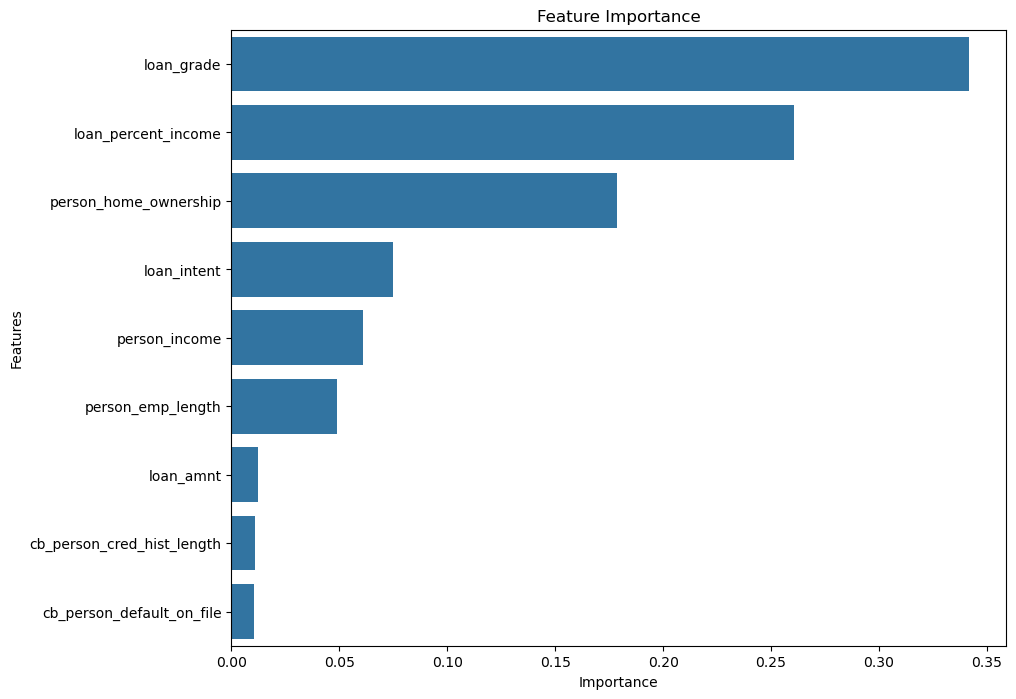

In [13]:
# plot feature importance
plt.figure(figsize=(10, 8))
sns.barplot(data=feature_importances, x="Importance", y="Features")
plt.title("Feature Importance")
plt.show()

# Calibration

## Platt Calibration

In [14]:
# --- 1) Prefit calibration models (validation set) ---
platt = CalibratedClassifierCV(estimator=xgb_model, method="sigmoid", cv="prefit")
platt.fit(X_va, y_va)

c:\Users\User\.conda\envs\classification_calibration\lib\site-packages\sklearn\calibration.py:330: FutureWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(


,estimator,"XGBClassifier...ree=None, ...)"
,method,'sigmoid'
,cv,'prefit'
,n_jobs,None
,ensemble,'auto'
,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None


In [15]:
proba_tr_platt = platt.predict_proba(X_tr)[:, 1]
proba_va_platt = platt.predict_proba(X_va)[:, 1]
proba_te_platt = platt.predict_proba(X_te)[:, 1]

In [16]:
print('Tra:', model_metrics(y_tr, proba_tr_platt, threshold=0.5))

print('Val:', model_metrics(y_va, proba_va_platt, threshold=0.5))

print('Tes:', model_metrics(y_te, proba_te_platt, threshold=0.5))

Tra: {'ROC_AUC': 0.956, 'Balanced_Accuracy': 0.863, 'Precision': 0.974, 'Recall': 0.731, 'F1': 0.835, 'LogLoss': 0.189}
Val: {'ROC_AUC': 0.942, 'Balanced_Accuracy': 0.866, 'Precision': 0.968, 'Recall': 0.738, 'F1': 0.838, 'LogLoss': 0.198}
Tes: {'ROC_AUC': 0.938, 'Balanced_Accuracy': 0.853, 'Precision': 0.967, 'Recall': 0.714, 'F1': 0.821, 'LogLoss': 0.207}


In [17]:
print('Tra', calibration_metrics(y_tr, proba_tr_platt, "Platt Scaling"))
print('Val', calibration_metrics(y_va, proba_va_platt, "Platt Scaling"))
print('Tes', calibration_metrics(y_te, proba_te_platt, "Platt Scaling"))

Tra {'Method': 'Platt Scaling', 'Log Loss': 0.189, 'Brier Score': 0.052, 'ECE': 0.017}
Val {'Method': 'Platt Scaling', 'Log Loss': 0.198, 'Brier Score': 0.053, 'ECE': 0.006}
Tes {'Method': 'Platt Scaling', 'Log Loss': 0.207, 'Brier Score': 0.057, 'ECE': 0.008}


## Isotonic Calibration

In [18]:
isotonic = CalibratedClassifierCV(estimator=xgb_model, method="isotonic", cv="prefit")
isotonic.fit(X_va, y_va)

c:\Users\User\.conda\envs\classification_calibration\lib\site-packages\sklearn\calibration.py:330: FutureWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(


,estimator,"XGBClassifier...ree=None, ...)"
,method,'isotonic'
,cv,'prefit'
,n_jobs,None
,ensemble,'auto'
,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None


In [19]:
proba_tr_iso = isotonic.predict_proba(X_tr)[:, 1]
proba_va_iso = isotonic.predict_proba(X_va)[:, 1]
proba_te_iso = isotonic.predict_proba(X_te)[:, 1]

In [20]:
print('Tra:', model_metrics(y_tr, proba_tr_iso, threshold=0.5))

print('Val:', model_metrics(y_va, proba_va_iso, threshold=0.5))

print('Tes:', model_metrics(y_te, proba_te_iso, threshold=0.5))

Tra: {'ROC_AUC': 0.956, 'Balanced_Accuracy': 0.864, 'Precision': 0.972, 'Recall': 0.734, 'F1': 0.836, 'LogLoss': 0.194}
Val: {'ROC_AUC': 0.944, 'Balanced_Accuracy': 0.868, 'Precision': 0.965, 'Recall': 0.743, 'F1': 0.839, 'LogLoss': 0.183}
Tes: {'ROC_AUC': 0.937, 'Balanced_Accuracy': 0.854, 'Precision': 0.963, 'Recall': 0.716, 'F1': 0.821, 'LogLoss': 0.267}


In [21]:
print('Tra:', calibration_metrics(y_tr, proba_tr_iso, "Isotonic Regression"))
print('Val:', calibration_metrics(y_va, proba_va_iso, "Isotonic Regression"))
print('Tes:', calibration_metrics(y_te, proba_te_iso, "Isotonic Regression"))

Tra: {'Method': 'Isotonic Regression', 'Log Loss': 0.194, 'Brier Score': 0.052, 'ECE': 0.016}
Val: {'Method': 'Isotonic Regression', 'Log Loss': 0.183, 'Brier Score': 0.052, 'ECE': 0.0}
Tes: {'Method': 'Isotonic Regression', 'Log Loss': 0.267, 'Brier Score': 0.056, 'ECE': 0.011}


## Venn-ABERS calibration

### Inductive

In [22]:
p_train = xgb_model.predict_proba(X_tr)
p_cal = xgb_model.predict_proba(X_va)
p_test = xgb_model.predict_proba(X_te)

In [23]:
VAC = VennAbersCalibrator()
proba_tr_iva, intervals_tr_iva = VAC.predict_proba(p_cal=p_cal, y_cal=y_va.values, p_test=p_train, p0_p1_output=True)
proba_val_iva, intervals_val_iva = VAC.predict_proba(p_cal=p_cal, y_cal=y_va.values, p_test=p_cal, p0_p1_output=True)
proba_test_iva, proba_te_iva = VAC.predict_proba(p_cal=p_cal, y_cal=y_va.values, p_test=p_test, p0_p1_output=True)

In [24]:
proba_tr_iva = proba_tr_iva[:,1]
proba_val_iva = proba_val_iva[:,1]
proba_te_iva = proba_test_iva[:,1]

In [25]:
print('Tra:', model_metrics(y_tr, proba_tr_iva, 0.5))
print('Val:', model_metrics(y_va, proba_val_iva, 0.5))
print('Tes:', model_metrics(y_te, proba_te_iva, 0.5))

Tra: {'ROC_AUC': 0.956, 'Balanced_Accuracy': 0.864, 'Precision': 0.972, 'Recall': 0.733, 'F1': 0.836, 'LogLoss': 0.182}
Val: {'ROC_AUC': 0.943, 'Balanced_Accuracy': 0.867, 'Precision': 0.967, 'Recall': 0.741, 'F1': 0.839, 'LogLoss': 0.186}
Tes: {'ROC_AUC': 0.938, 'Balanced_Accuracy': 0.854, 'Precision': 0.963, 'Recall': 0.715, 'F1': 0.821, 'LogLoss': 0.201}


In [26]:
print('Tra:', calibration_metrics(y_tr, proba_tr_iva, "Inductive Venn-ABERS"))
print('Val:', calibration_metrics(y_va, proba_val_iva, "Inductive Venn-ABERS"))
print('Tes:', calibration_metrics(y_te, proba_te_iva, "Inductive Venn-ABERS"))

Tra: {'Method': 'Inductive Venn-ABERS', 'Log Loss': 0.182, 'Brier Score': 0.052, 'ECE': 0.017}
Val: {'Method': 'Inductive Venn-ABERS', 'Log Loss': 0.186, 'Brier Score': 0.052, 'ECE': 0.005}
Tes: {'Method': 'Inductive Venn-ABERS', 'Log Loss': 0.201, 'Brier Score': 0.056, 'ECE': 0.008}


### Cross Venn-ABERS

In [27]:
# combine training and validation for cross Venn-ABERS

X_cvap = pd.concat([X_tr, X_va], axis=0, ignore_index=True)
y_cvap = pd.concat([y_tr, y_va], axis=0, ignore_index=True)

In [28]:
# --- CVAP (cross Venn–Abers) ---
va_cross = VennAbersCalibrator(
    estimator=XGBClassifier(
        n_estimators=50,
        learning_rate=0.1,
        max_depth=7,
        random_state=42
    ),
    inductive=False,
    n_splits=5,   
    random_state=42
)

In [29]:
va_cross.fit(X_cvap, y_cvap)
# va_cross.fit(X_tr, y_tr)

In [30]:
proba_train_cva, intervals_tr_cva = va_cross.predict_proba(X_tr, p0_p1_output=True)
proba_val_cva, intervals_val_cva = va_cross.predict_proba(X_va, p0_p1_output=True)
proba_test_cva, intervals_te_cva = va_cross.predict_proba(X_te, p0_p1_output=True)

In [31]:
proba_tr_cva = proba_train_cva[:,1]
proba_val_cva = proba_val_cva[:,1]
proba_te_cva = proba_test_cva[:,1]

In [32]:
# print model performance
print('Tra:', model_metrics(y_tr, proba_tr_cva, 0.5))
print('Val:', model_metrics(y_va, proba_val_cva, 0.5))
print('Test:', model_metrics(y_te, proba_te_cva, 0.5))  

Tra: {'ROC_AUC': 0.952, 'Balanced_Accuracy': 0.855, 'Precision': 0.982, 'Recall': 0.714, 'F1': 0.826, 'LogLoss': 0.187}
Val: {'ROC_AUC': 0.959, 'Balanced_Accuracy': 0.868, 'Precision': 0.988, 'Recall': 0.739, 'F1': 0.845, 'LogLoss': 0.172}
Test: {'ROC_AUC': 0.938, 'Balanced_Accuracy': 0.851, 'Precision': 0.981, 'Recall': 0.707, 'F1': 0.822, 'LogLoss': 0.199}


In [33]:
# print calibration performance
print('Tra:', calibration_metrics(y_tr, proba_tr_cva, "Cross Venn-ABERS"))
print('Val:', calibration_metrics(y_va, proba_val_cva, "Cross Venn-ABERS"))
print('Test:', calibration_metrics(y_te, proba_te_cva, "Cross Venn-ABERS"))

Tra: {'Method': 'Cross Venn-ABERS', 'Log Loss': 0.187, 'Brier Score': 0.053, 'ECE': 0.017}
Val: {'Method': 'Cross Venn-ABERS', 'Log Loss': 0.172, 'Brier Score': 0.048, 'ECE': 0.019}
Test: {'Method': 'Cross Venn-ABERS', 'Log Loss': 0.199, 'Brier Score': 0.056, 'ECE': 0.009}


# Comparison of Calibrations


Calibration Performance (Test Set):


,Log Loss,Brier Score,ECE
Method,,,
Raw (Uncalibrated),0.203,0.056,0.012
Platt Scaling,0.207,0.057,0.008
Isotonic Regression,0.267,0.056,0.011
Venn-Abers (IVAP),0.201,0.056,0.008
Venn-Abers (CVAP),0.199,0.056,0.009


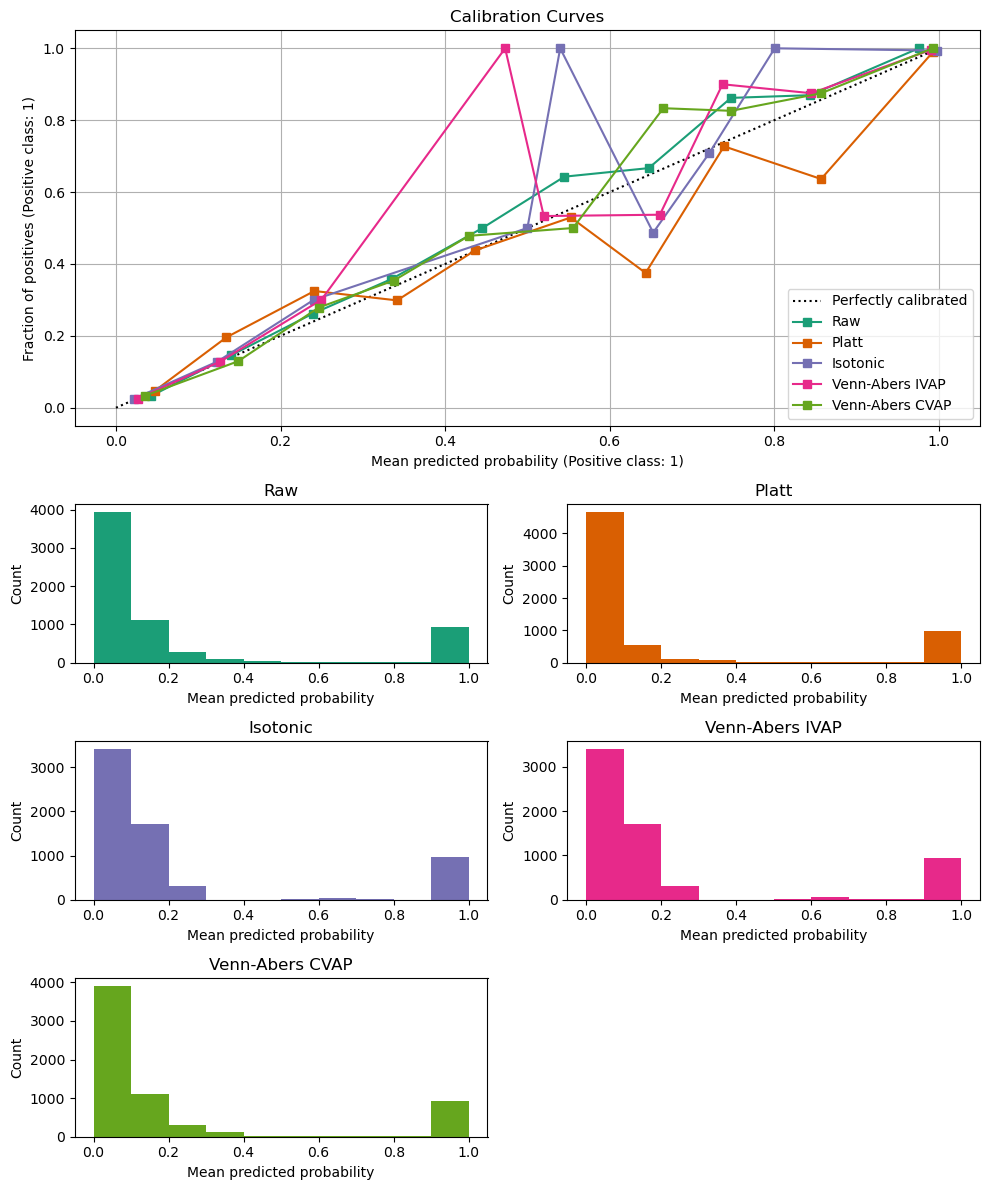

In [ ]:
results = []
results.append(calibration_metrics(y_te, proba_te,      "Raw (Uncalibrated)"))
results.append(calibration_metrics(y_te, proba_te_platt,    "Platt Scaling"))
results.append(calibration_metrics(y_te, proba_te_iso,      "Isotonic Regression"))
results.append(calibration_metrics(y_te, proba_te_iva,       "Venn-Abers (IVAP)"))
results.append(calibration_metrics(y_te, proba_te_cva,     "Venn-Abers (CVAP)"))

calib_df = pd.DataFrame(results).set_index("Method").round(4)
print("\nCalibration Performance (Test Set):")
display(calib_df)



pred_list = [
    (proba_te, "Raw"),
    (proba_te_platt, "Platt"),
    (proba_te_iso, "Isotonic"),
    (proba_te_iva, "Venn-Abers IVAP"),
    (proba_te_cva, "Venn-Abers CVAP"),
]

# --- Start of Changes ---

fig = plt.figure(figsize=(10, 12)) # Increased height slightly for better layout
# GridSpec to 5 rows to make space for the 5th histogram
gs = GridSpec(5, 2)
colors = plt.get_cmap("Dark2")

ax_calibration_curve = fig.add_subplot(gs[:2, :2])
calibration_displays = {}
for i, (pred, name) in enumerate(pred_list):
    show = CalibrationDisplay.from_predictions(
        y_te,
        pred,
        n_bins=10,
        name=name,
        ax=ax_calibration_curve,
        color=colors(i),
    )
    calibration_displays[name] = show

ax_calibration_curve.grid()
ax_calibration_curve.set_title("Calibration Curves")

# 2. Added the 5th coordinate for the "Venn-Abers CVAP" plot
grid_positions = [(2, 0), (2, 1), (3, 0), (3, 1), (4, 0)]

# --- End of Changes ---

for i, (_, name) in enumerate(pred_list):
    row, col = grid_positions[i]
    ax = fig.add_subplot(gs[row, col])

    ax.hist(
        calibration_displays[name].y_prob,
        range=(0, 1),
        bins=10,
        label=name,
        color=colors(i),
    )
    ax.set(title=name, xlabel="Mean predicted probability", ylabel="Count")

plt.tight_layout()
plt.show()

# Save predictions

In [21]:
# --- Validation CSV ---
val_df = pd.DataFrame({
    "ID": df_va[ID_COL].values,
    "raw_prob": xgb_model.predict_proba(X_va)[:,1],
    "platt_prob": platt.predict_proba(X_va)[:,1],
    "isotonic_prob": isotonic.predict_proba(X_va)[:,1],
    "va_ind_prob": VAC.predict_proba(p_cal=p_cal, y_cal=y_va.values, p_test=p_cal, p0_p1_output=False)[:,1],
    "va_cross_prob": va_cross.predict_proba(X_va)[:,1],
})
val_df.to_csv("validation_calibration_outputs.csv", index=False)

# --- Test CSV ---
test_df = pd.DataFrame({
    "ID": df_te[ID_COL].values,
    "raw_prob": proba_raw,
    "platt_prob": proba_platt,
    "isotonic_prob": proba_iso,
    "va_ind_prob": p_va_ind,
    "va_cross_prob": p_va_cross,
})
test_df.to_csv("test_calibration_outputs.csv", index=False)
